In [1]:
import os
from astropy.table import Table, vstack, Column
from astropy.io import ascii
import scipy, pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfits

/u/tmakinen/anaconda3/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
legacyid = Table.read("legacy-brick-id.csv")

lsbg_tab = Table()

for i in range(len(legacyid['brick'])):
    brick = legacyid['brick'][i]      # get brick number and objid from the csv file for Johnny's objects
    objid = legacyid['objid'][i]      # get objid from the csv file for Johnny's objects
    trctr = brick[0:3]                # cut out first three digits to get the tractor file number
    
    fname = '/scratch/jgreco/tractor/%s/tractor-%s.fits' %(trctr, brick)
    
    tab = Table.read(fname)           # create a table for each filename
    
    lsbg_tab = vstack([lsbg_tab, tab[objid]])   # stack every desired row into the lsbg table for reference


In [3]:
big_table = Table.read('tractor191color.csv')

In [4]:
# Make cuts to clean up the big table data 
keep = (big_table['flux_r']>0.0) & (big_table['flux_r']<1e3)

keep = (big_table['type']!="PSF ")

cname = big_table.colnames[3:]  # want everything except ra, dec data
for i in range(len(cname)):
    keep &= (big_table[cname[i]]>0.0) & (big_table[cname[i]]<1e3)
    keep &= ~np.isnan(big_table[cname[i]])
    keep &= ~np.isinf(big_table[cname[i]])

t = big_table[keep]

In [5]:
magg = (22.5-2.5*np.log10(t["flux_g"]))
magr = (22.5-2.5*np.log10(t["flux_r"]))
magz = (22.5-2.5*np.log10(t["flux_z"]))
ap_g = (22.5-2.5*np.log10(t["apflux_2.0_g"]))
ap_r = (22.5-2.5*np.log10(t["apflux_2.0_r"]))
ap_z = (22.5-2.5*np.log10(t["apflux_2.0_z"]))

# make magnitude cuts to clean up data
mask = (magg < 22.5)
mask &= (ap_g < 22.5)
mask &= (magr<23.) & (magz<23.)
mask &= (ap_r<23.) & (ap_z<23.)

t2 = t[mask]

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


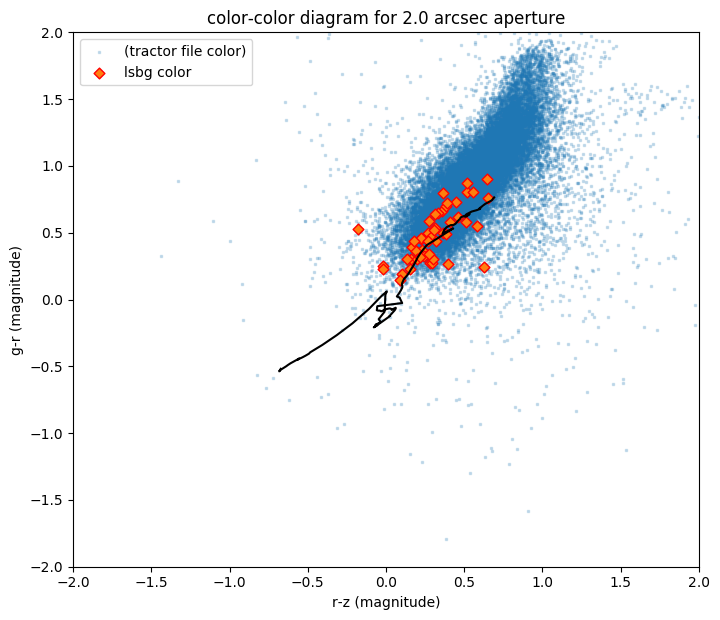

In [11]:
#------make the color-color (g-r), (r-z) band plot for aperture (data) fluxes----#
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)

# get lsbg aperture fluxes for 2.0 arcsec aperture
lsbg_apflux_r = 22.5 - 2.5*np.log10(lsbg_tab['apflux_r'][:,4])
lsbg_apflux_g = 22.5 - 2.5*np.log10(lsbg_tab['apflux_g'][:,4])
lsbg_apflux_z = 22.5 - 2.5*np.log10(lsbg_tab['apflux_z'][:,4])

# for tractor file
#mag_r = 22.5 - 2.5*np.log10(t2['apflux_2.0_r'])
#mag_g = 22.5 - 2.5*np.log10(t2['apflux_2.0_g'])
#mag_z = 22.5 - 2.5*np.log10(t2['apflux_2.0_z'])

# Do the subtraction for ratio of logs

lsgb_gr = lsbg_apflux_g - lsbg_apflux_r
lsgb_rz = lsbg_apflux_r - lsbg_apflux_z

#mag_gr = mag_g - mag_r
#mag_rz = mag_r - mag_z

ap_gr = ap_g[mask] - ap_r[mask]
ap_rz = ap_r[mask] - ap_z[mask]


# make scatterplots 
sctrac = ax1.scatter(ap_rz, ap_gr, s=1, marker = "s", alpha=0.2, label = '(tractor file color)')
sc = ax1.scatter(lsgb_rz, lsgb_gr, s=30, marker='D', alpha=1, edgecolors='r', label='lsbg color')

# add johnny's function
fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
plt.plot(r-z, g-r, color='k') 



plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.title('color-color diagram for 2.0 arcsec aperture')
plt.xlabel('r-z (magnitude)')
plt.ylabel('g-r (magnitude)')

plt.legend(loc='best')
plt.tight_layout()

plt.show()

/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/u/tmakinen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


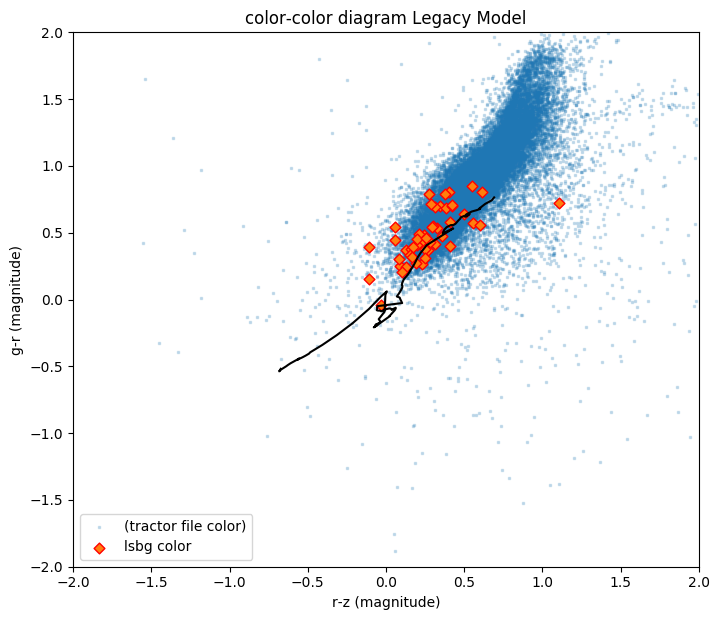

In [10]:
#------make the color-color (g-r), (r-z) band plot for the model fluxes----#
plt.style.use('default')
fig = plt.figure(221, figsize=(7.3, 6.3))
ax1 = plt.subplot(111)


# convert out of nanomaggies for lsbg table (lol) #
lsbg_mag_r = 22.5 - 2.5*np.log10(lsbg_tab['flux_r'])
lsbg_mag_g = 22.5 - 2.5*np.log10(lsbg_tab['flux_g'])
lsbg_mag_z = 22.5 - 2.5*np.log10(lsbg_tab['flux_z'])

# for tractor file
mag_r = 22.5 - 2.5*np.log10(t2['flux_r'])
mag_g = 22.5 - 2.5*np.log10(t2['flux_g'])
mag_z = 22.5 - 2.5*np.log10(t2['flux_z'])

# Do the subtraction for ratio of logs

lsgb_gr = lsbg_mag_g - lsbg_mag_r
lsgb_rz = lsbg_mag_r - lsbg_mag_z

mag_gr = mag_g - mag_r
mag_rz = mag_r - mag_z


# make scatterplots 
sctrac = ax1.scatter(mag_rz, mag_gr, s=1, marker = "s", alpha=0.2, label = '(tractor file color)')
sc = ax1.scatter(lsgb_rz, lsgb_gr, s=30, marker='D', alpha=1, edgecolors='r', label='lsbg color')

# add johnny's function
fn = 'bc2003_lr_BaSeL_m52_chab_ssp.1ABmag'
age, u, g, r, i, z = np.loadtxt(fn, unpack=True, usecols=(0,1,2,3,4,5))
plt.plot(r-z, g-r, color='k') 



plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.title('color-color diagram Legacy Model')
plt.xlabel('r-z (magnitude)')
plt.ylabel('g-r (magnitude)')

plt.legend(loc='best')
plt.tight_layout()

plt.show()